In [1]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.example_libraries import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi


In [2]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):
    
    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(12,1))
        
    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0,0.5))
        
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

args = {"n": 625,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(2),
        "batch_size": 15
}

n_xy = 25
grid = jnp.arange(0, 1, 1/n_xy)
u, v = jnp.meshgrid(grid, grid)
x_xy = jnp.array([u.flatten(), v.flatten()]).transpose((1, 0))
dist_ = dist_euclid(x_xy, x_xy)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=args["batch_size"])

In [3]:
batch = gp_predictive(rng_key, gp_kernel=args["gp_kernel"], x=x_xy, jitter=1e-4)

In [4]:
batch['kernel_length']

DeviceArray([0.09411903, 0.12481795, 0.06208865, 0.13207124, 0.16304046,
             0.11788849, 0.0991427 , 0.0864901 , 0.08737124, 0.06931929,
             0.05696422, 0.08966597, 0.0749783 , 0.10016549, 0.07483231],            dtype=float32)

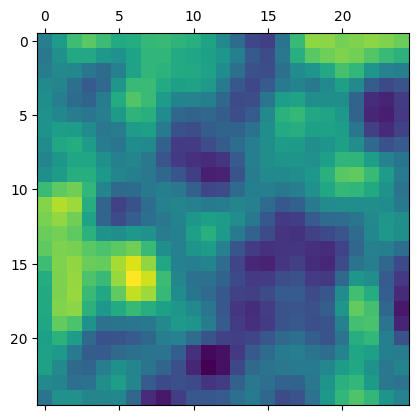

In [5]:
plt.matshow(batch['y'][14].reshape(25,25))

In [6]:
def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Elu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(out_dim, W_init=stax.randn()) 
    )

def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((batch.shape[0],z_dim)), jnp.ones((batch.shape[0],z_dim))))
    gen_loc = decode(z)    
    return numpyro.sample("obs", dist.Normal(gen_loc, .1), obs=batch) 
    

def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

In [7]:
decoder_nn = vae_decoder(50, 75, 625)
with open('../output/decoder/2d_decoder_15_5_large.pkl','rb') as f:
    decoder_params = pickle.load(f)

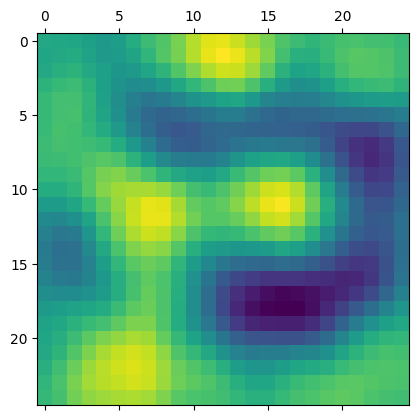

In [12]:
r = decoder_nn[1](decoder_params, np.random.normal(size=20)).reshape(25,25)
plt.matshow(r)

# Test Model

In [1]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_bg(T):
    centers = np.random.normal(scale = 1.5, size=10).reshape(5,2)
    print(centers)
    n = np.random.poisson(np.random.gamma(50,1,size=5),size=5)
    bg = list()
    for i in range(5):
        bg.append(np.stack((np.random.normal(loc=centers[i,0],size=n[i]),
                                   np.random.normal(loc=centers[i,1],size=n[i]),
                                   np.random.uniform(size=n[i])*T)).T)
    return np.concatenate(bg)

def gen_dat(par,T):
    r_0, b, sigma_1, sigma_2 = par
    #bg = gen_bg(T)
    n_bg = np.random.poisson(250,size=1)
    bg = np.stack((np.random.normal(size=n_bg),np.random.normal(size=n_bg),np.random.uniform(size=n_bg)*T)).T
    i = 0
    while i < len(bg):
        for j in range(np.random.poisson(lam=r_0)):
            bg = np.concatenate((bg,[bg[i]+[np.random.normal(scale=sigma_1), 
                                           np.random.normal(scale=sigma_2), 
                                           np.random.exponential(b)]]))
        i += 1
    return bg
par = np.array([.25,1,.1,.1])
events = gen_dat(par,365)
events = events[np.logical_and(abs(events.T[0])<5,abs(events.T[1])<5,events.T[2]<365)]
events = events[events[:, 2].argsort()]
len(events)

323

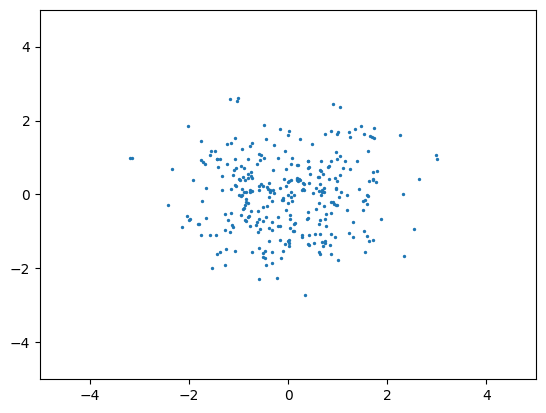

In [3]:
plt.scatter(events.T[0],events.T[1],s=2)
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.show()

In [4]:
import pandas as pd
xyt = pd.DataFrame(events,columns=['X','Y','T'])
A = np.array([[-5,5],[-5,5]])
model2 = Point_Process_Model(xyt,A,'cox_hawkes')

In [15]:
model2.run_mcmc()

sample: 100%|███████████████████████████| 1500/1500 [03:38<00:00,  6.87it/s, 127 steps of size 2.62e-02. acc. prob=0.93]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -2.10      1.11     -2.11     -3.78     -0.22    316.19      1.00
         alpha      0.28      0.02      0.28      0.25      0.32   1085.31      1.00
          beta      0.16      0.02      0.16      0.14      0.19    905.60      1.00
      sigmax_2      0.00      0.00      0.00      0.00      0.00   1142.94      1.00
  z_spatial[0]      0.59      0.13      0.59      0.38      0.81    413.31      1.00
  z_spatial[1]     -0.54      0.20     -0.53     -0.86     -0.25    292.76      1.00
  z_spatial[2]      0.26      0.13      0.26      0.07      0.47    404.23      1.00
  z_spatial[3]      0.38      0.09      0.38      0.24      0.52    332.17      1.00
  z_spatial[4]     -0.36      0.10     -0.36     -0.53     -0.20    492.64      1.00
  z_spatial[5]      0.14      0.12      0.14     -0.05      0.34    254.05      1.00
  z_spatial[6]      0.86      0.14      0.85      0.60      1.06

In [16]:
[.25,1*50/365,.1/10]

[0.25, 0.136986301369863, 0.01]

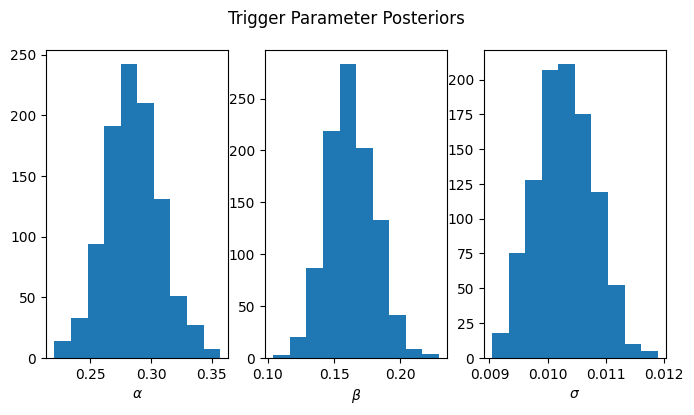

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.284719,0.022455,12.679533,0.0,0.242600,0.333269
beta,0.162745,0.017686,9.201856,0.0,0.130074,0.197616
sigma,0.010289,0.000491,20.975302,0.0,0.009396,0.011188


In [17]:
model2.plot_trigger_posterior()

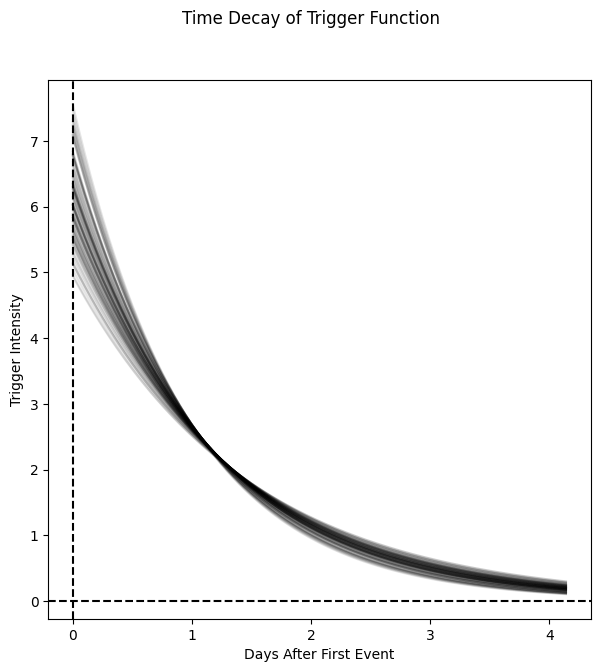

Mean trigger time: 1.19 days


In [18]:
model2.plot_trigger_time_decay()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:530: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


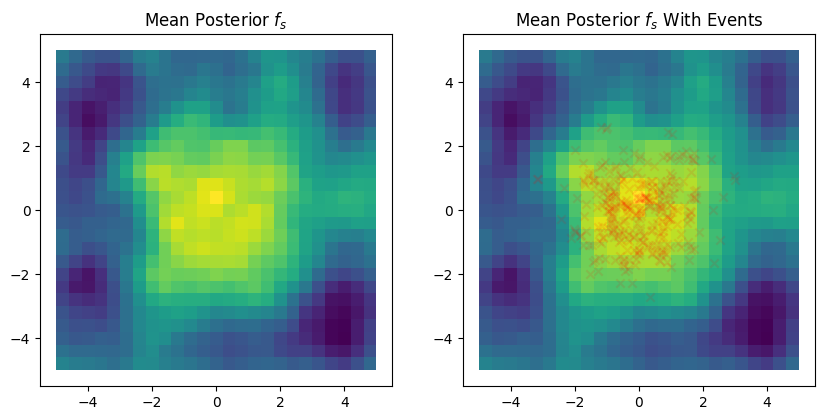

In [19]:
model2.plot_spatial_background(include_cov=False)

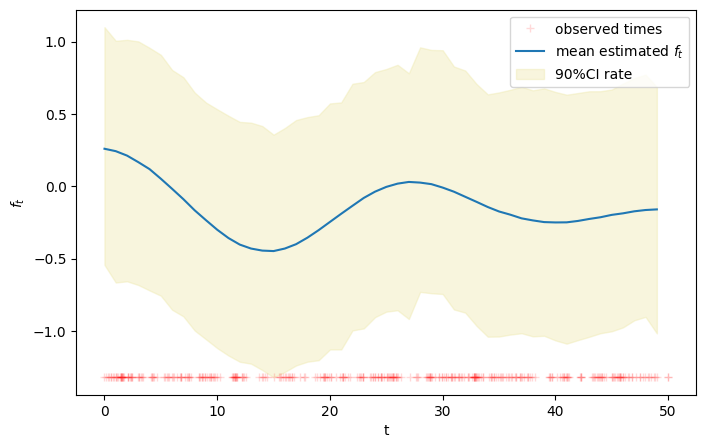

In [20]:
model2.plot_temporal_background()

## SVI

In [ ]:
model2.run_svi(num_steps=25000,resume=True)

 68%|██████████▊     | 16992/25000 [00:32<00:13, 584.84it/s, init loss: -1654.9630, avg. loss [15001-16250]: -1657.5876]

In [ ]:
model2.plot_trigger_posterior()

In [ ]:
model2.plot_temporal_background()

In [ ]:
model2.plot_spatial_background(include_cov=False)